[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pol-is/notebooks/blob/master/020-PCA.ipynb)

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph

import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA

In [106]:
## Set up plots
plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Import raw data && clean up

In [107]:
df = pd.read_csv('./participants-votes.csv',index_col='participant')
df_comments = pd.read_csv('./comments.csv',index_col='comment-id')

In [108]:
df_comments.index = df_comments.index.astype(str)

In [109]:
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

In [110]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [111]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`

## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold=7):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]
    
df = select_rows(df)

In [112]:
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

In [113]:
high_variance = [
    "20","26","90"
]

vals_high_variance = vals[high_variance]

statements_consensus = [
    "39","200","83","82","737","64","127","126","66",
]

vals_consensus = vals[consensus_statements]

consensus_disagree = [
    "353","779","720","354"
]

vals_consensus_disagree = vals[consensus_disagree]

statements_opiods = [
    "9",
    "19",
    "11",
    "10",
    "675",
    "753",
    "742",
    "336",
    "329",
    "683",
    "686",
    "894",
    "885",
    "846",
    "688",
    "679",
    "678",
    "676",
]
vals_opiods = vals[statements_opiods]


statements_homelessness = [
    "24","25","34","45","55",
    "103","105","106","147",
    "160","232","233",
    "404","535", 
    "586","782","828",
]
vals_homelessness = vals[statements_homelessness]
                              

vals_all_in = vals[statements_all_in]

# Overall stats

How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [114]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (838, 901)
Dimensions of matrix: (838, 896)
Total number of possible votes: 750848
Total number of agrees: 85111
Total number of disagrees: 30895
Total without vote: 634842
Percent sparse:  0.8455000213092397 %


### Full participants * comments matrix

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived. 

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation. 

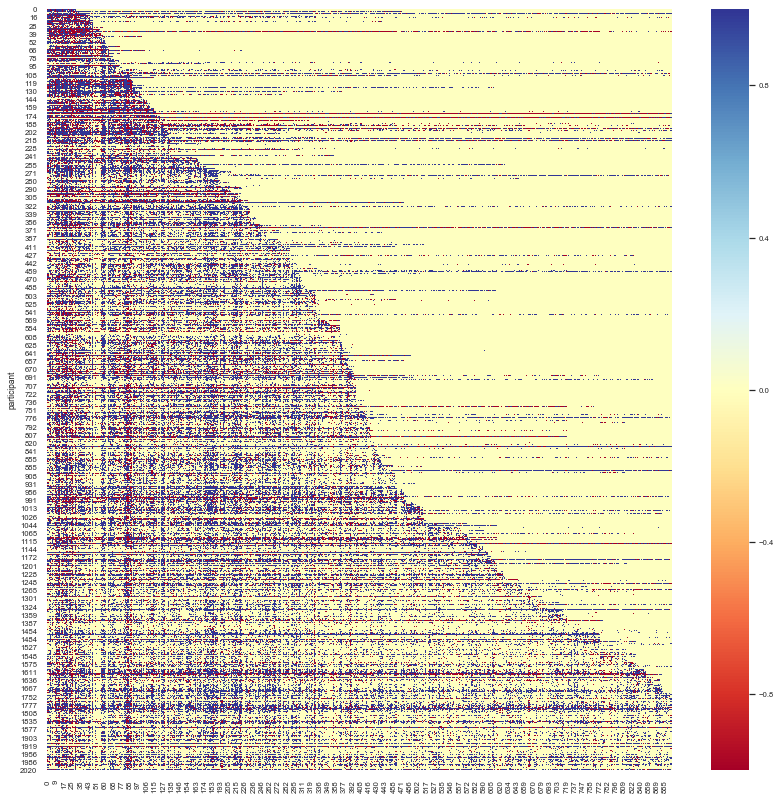

In [115]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)

In [116]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [117]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric='euclidean',
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape
    
    return embedding

In [118]:
def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    plt.show()

In [119]:
## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values, 
        neighbors, 
        mode="connectivity", 
        metric="minkowski", 
        p=3, 
        metric_params=None, 
        include_self=True, 
        n_jobs=None
    )

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g, 
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters] 

    #df["leiden"] = leidenClustersStr
    
    return leidenClusters

In [120]:
def polis_subconversation(dataframe, comments):
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    embedding = polis_umap(dataframe, 4)

    leidenClusters = polis_leiden(dataframe, 8)

    # Show clusters given umap embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    # Show clusters given pca embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    ax.set_title("Leiden detected communities in UMAP space", fontsize=14)
    plt.show()
    
    # Show clustermap
    dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = dataframe.groupby('leiden_cluster_assignments').agg('mean')

    #sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
    sns.clustermap(clusters_by_comments_means, cmap="RdYlBu")

    for x in comments:
        c(x, coords)
        c(x, embedding)

# Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial. 
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

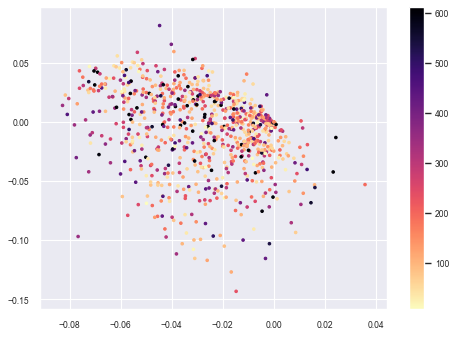

In [121]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

# High Variance

Explained variance: [0.1276214  0.07179229]


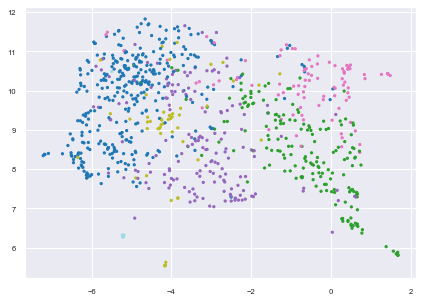

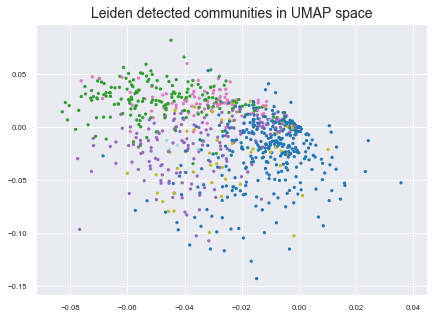

/Users/colinmegill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


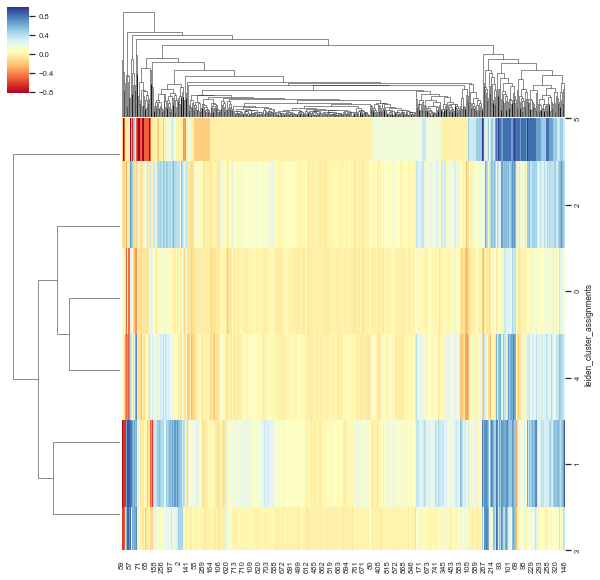

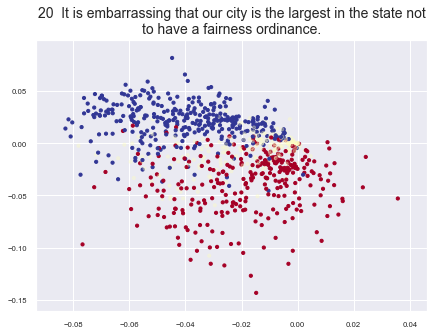

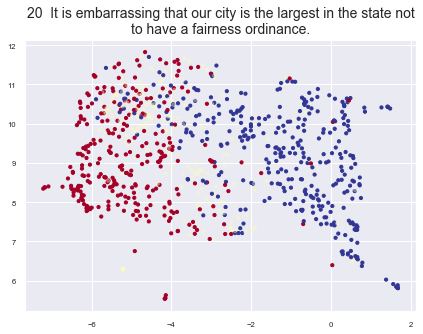

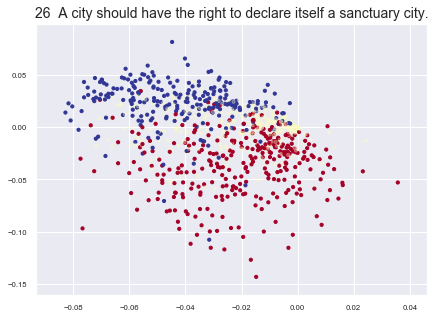

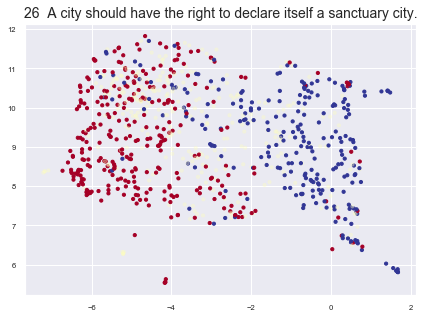

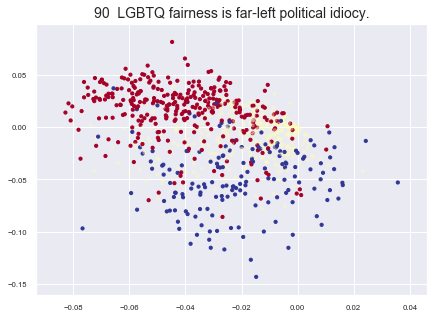

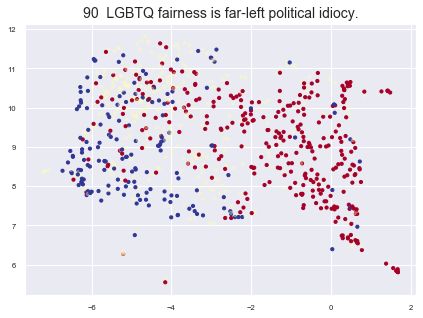

In [122]:
polis_subconversation(vals_all_in, high_variance)

# Consensus

Explained variance: [0.13507714 0.07016186]


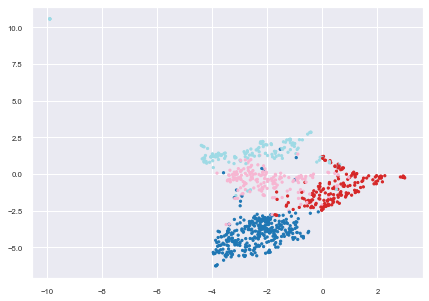

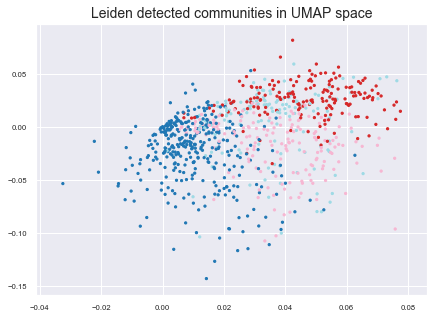

/Users/colinmegill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


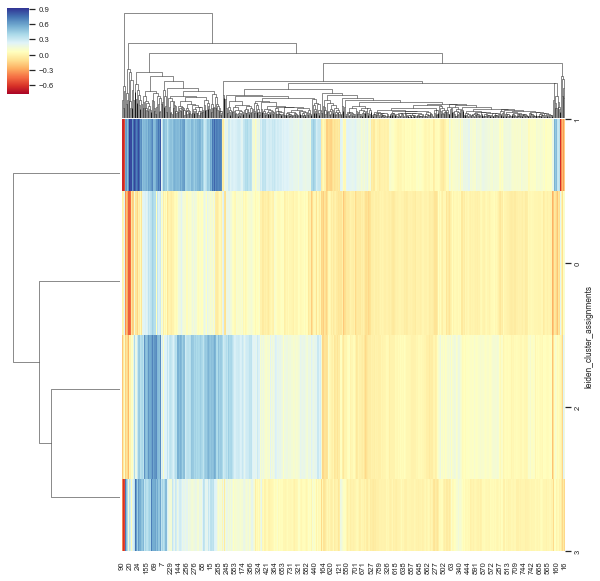

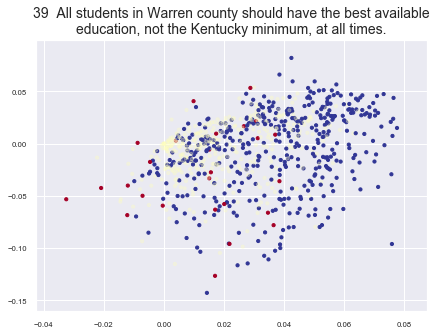

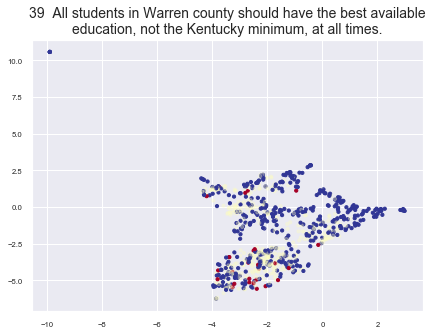

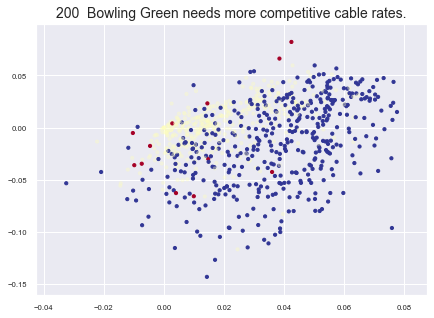

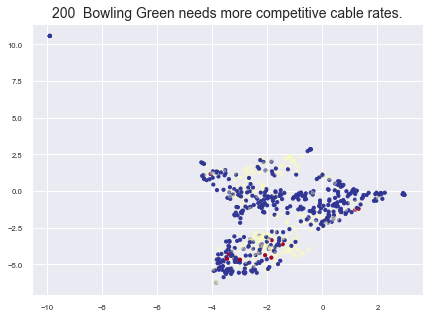

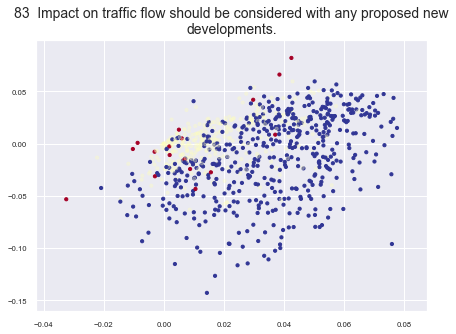

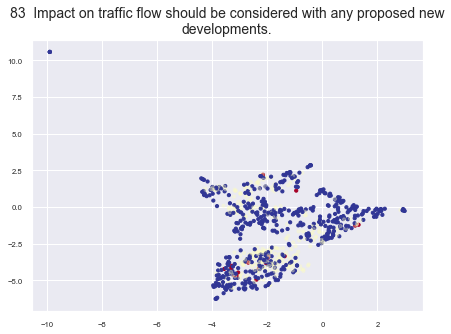

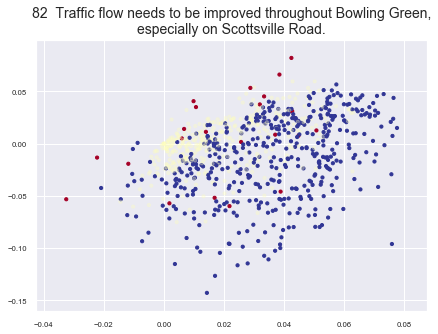

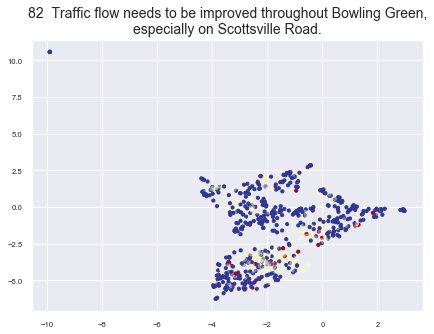

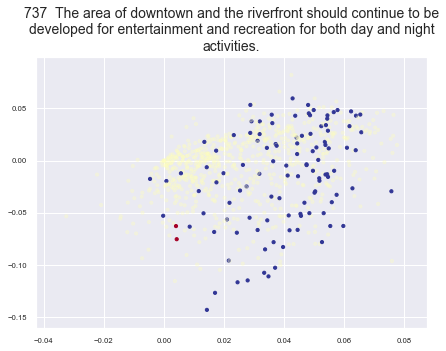

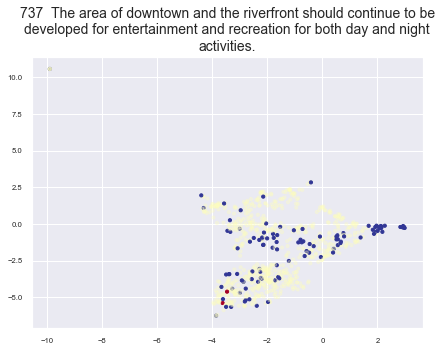

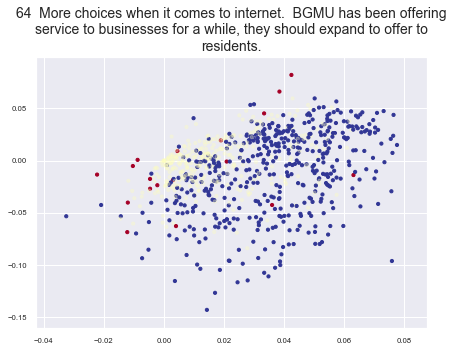

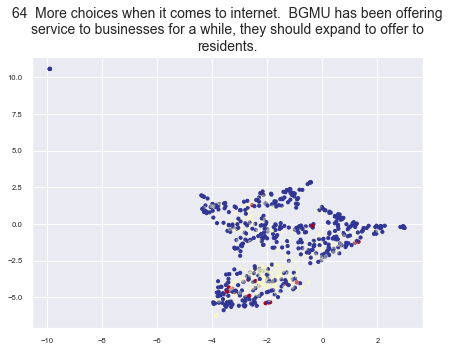

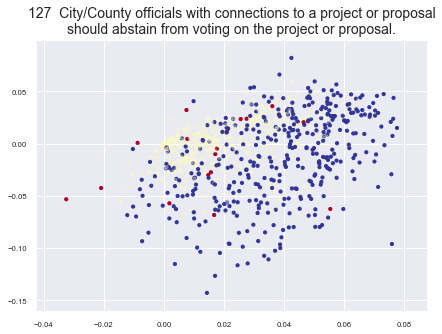

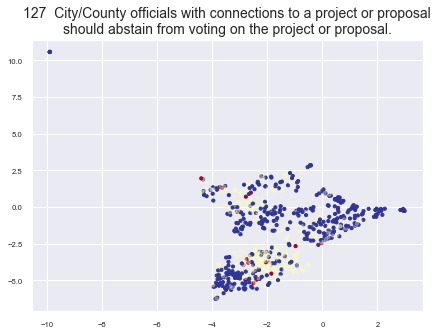

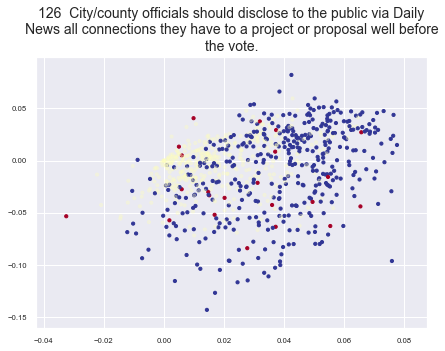

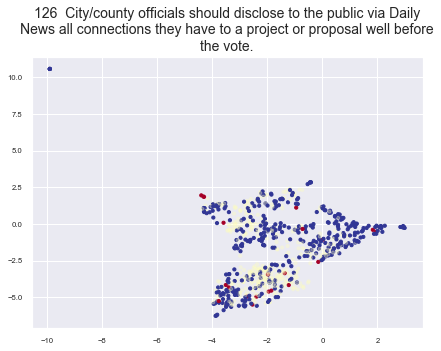

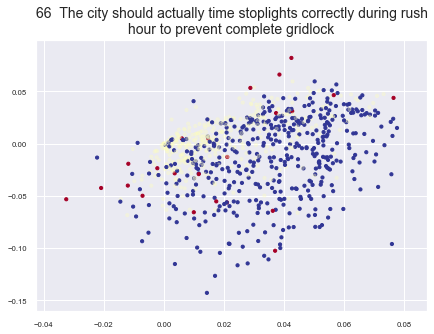

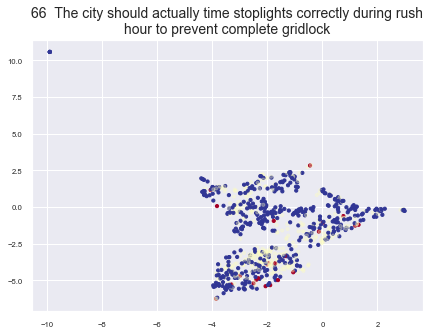

In [123]:
polis_subconversation(vals_all_in, statements_consensus)

# Opiods

Explained variance: [0.45522257 0.1130914 ]


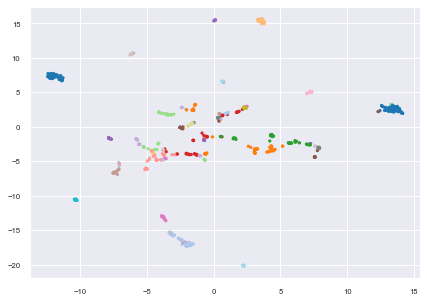

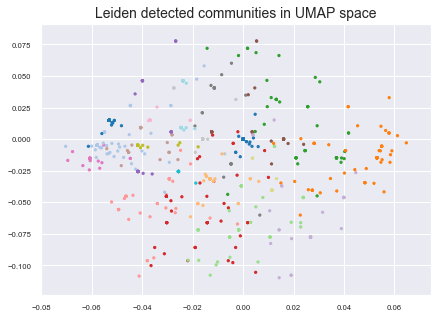

/Users/colinmegill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


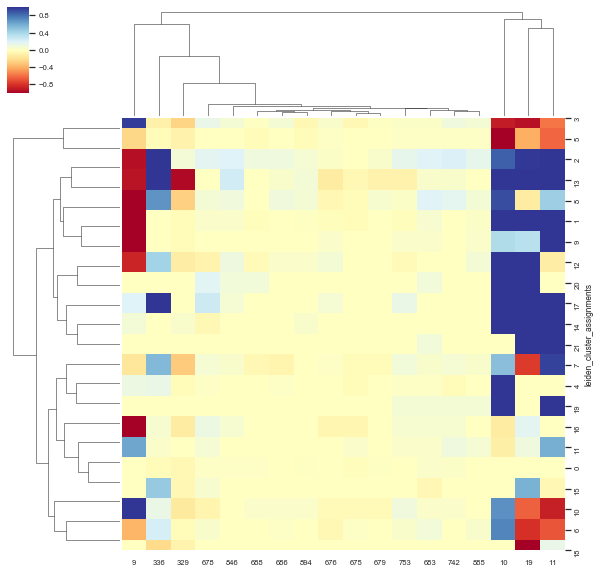

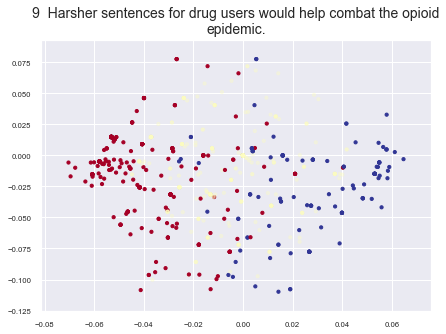

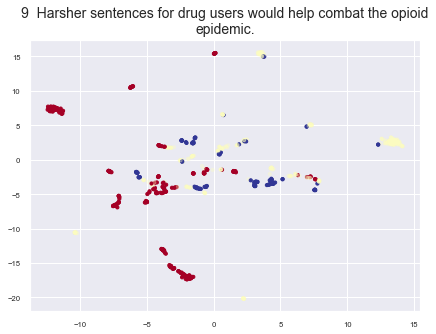

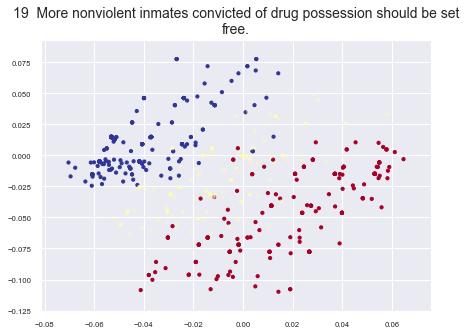

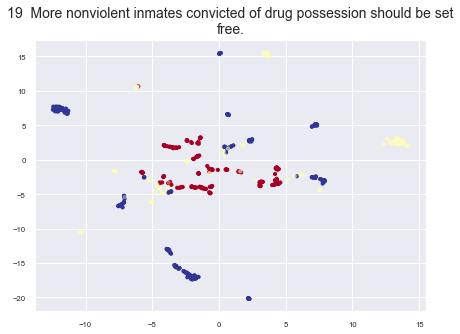

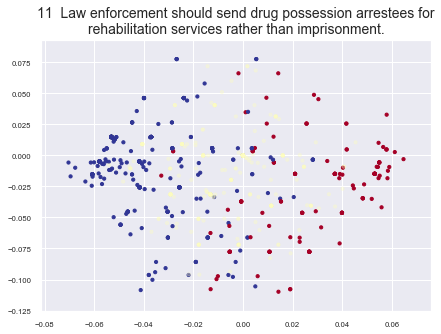

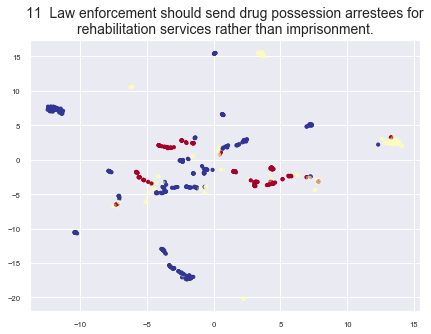

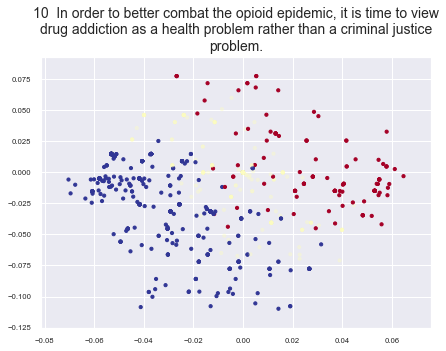

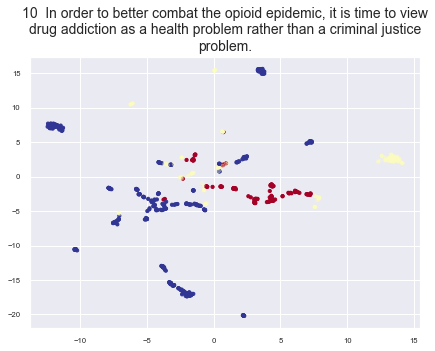

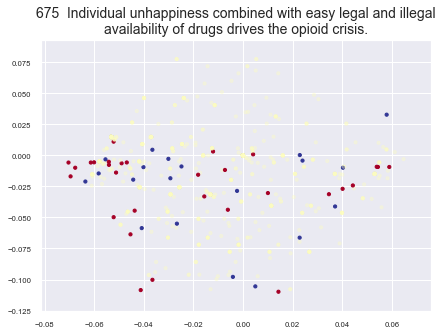

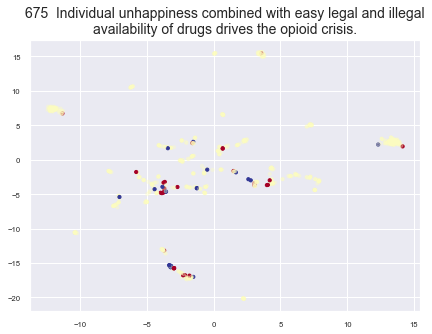

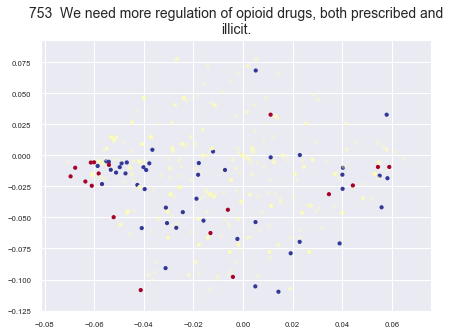

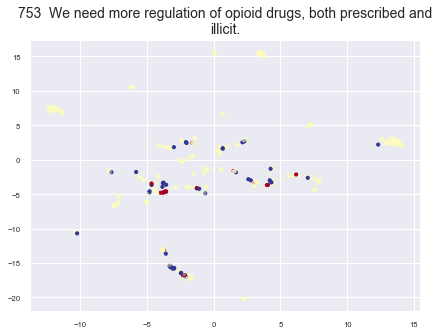

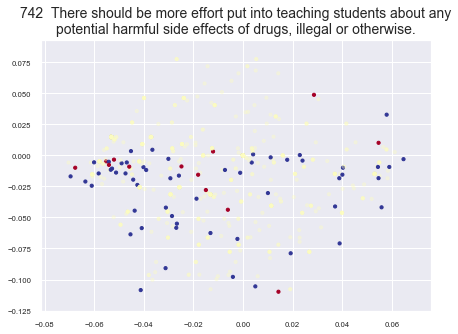

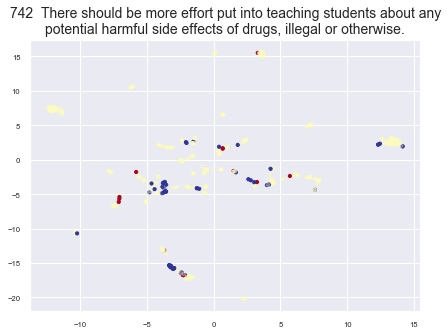

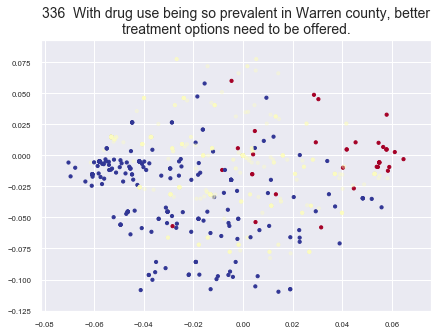

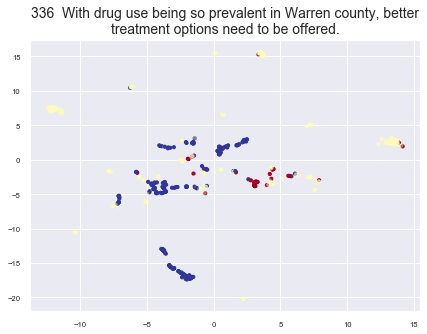

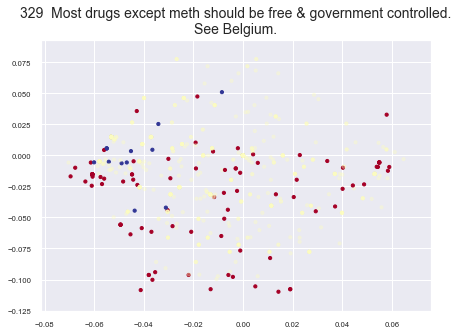

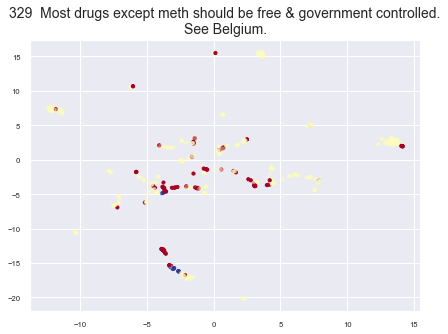

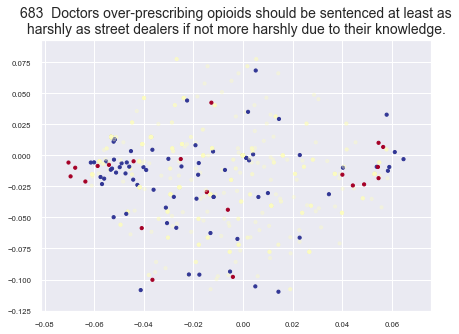

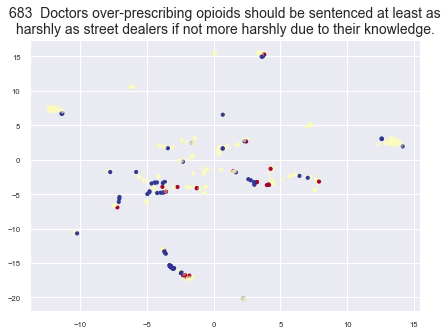

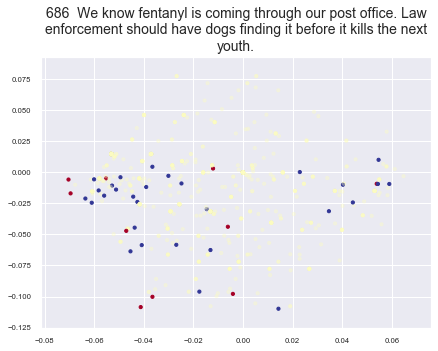

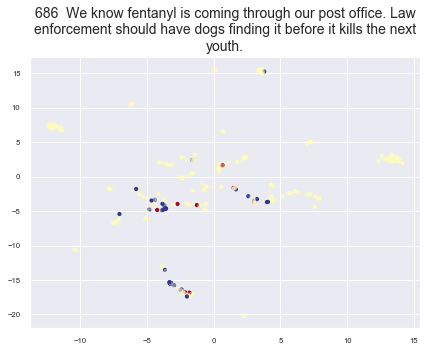

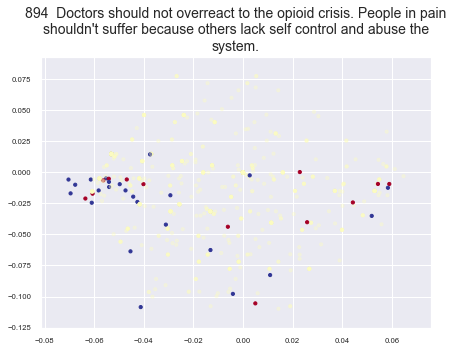

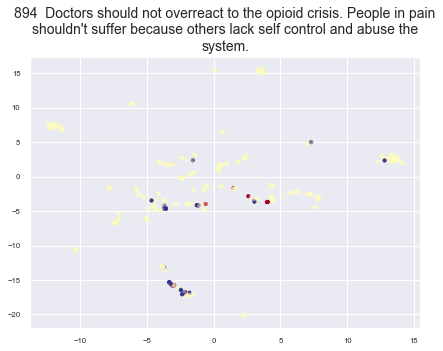

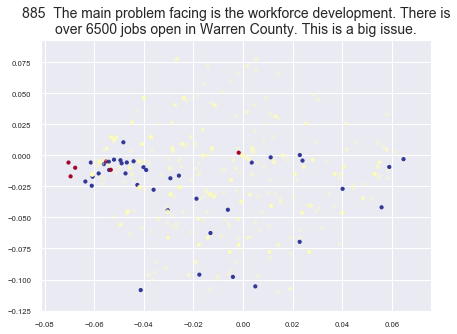

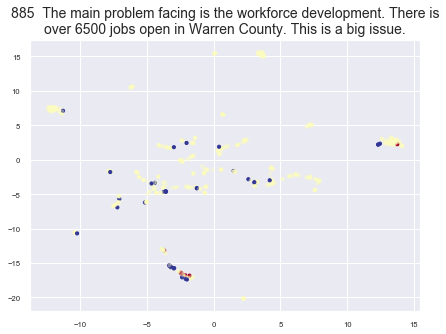

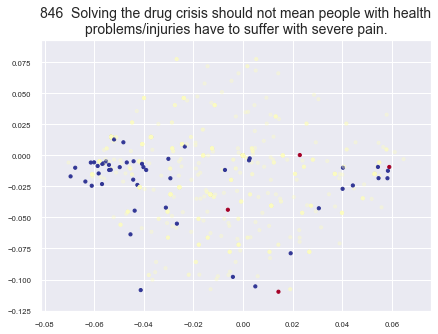

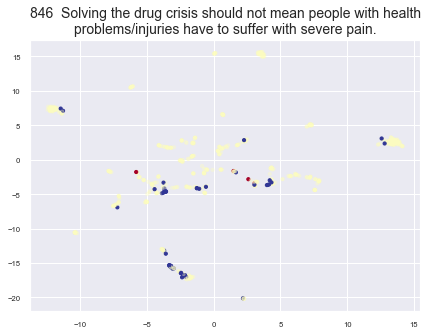

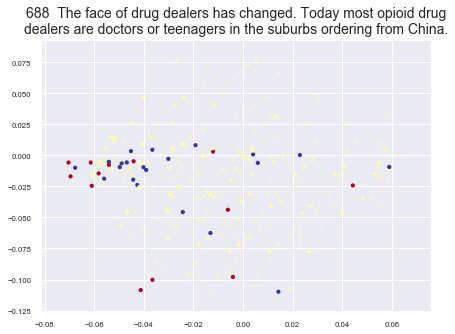

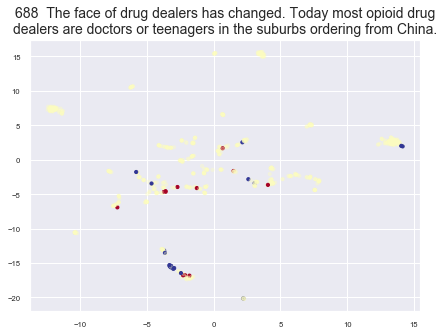

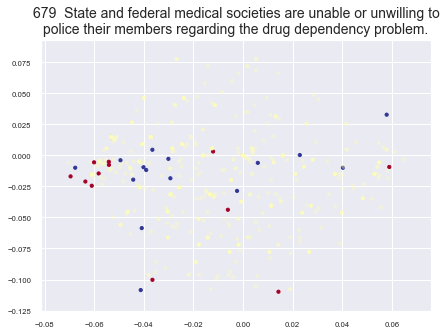

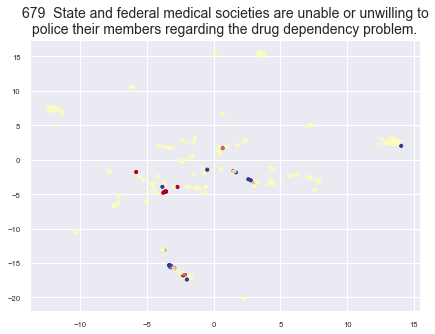

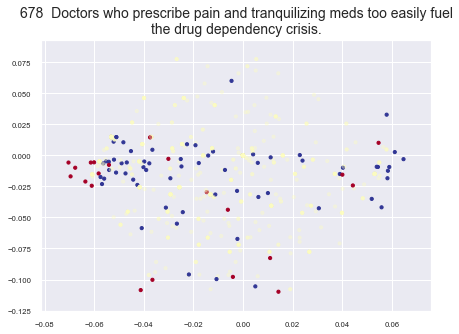

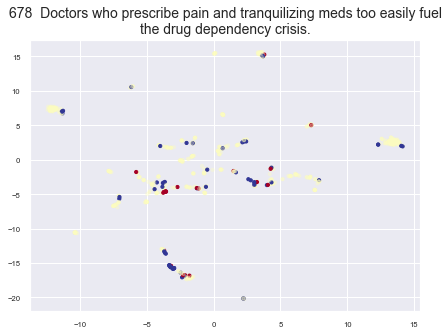

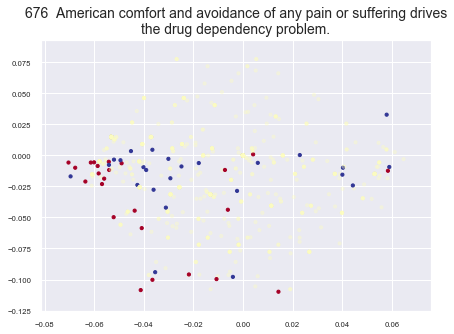

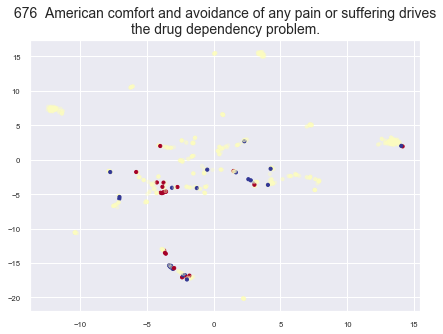

In [124]:
polis_subconversation(vals_opiods, statements_opiods)

# Homelessness

Explained variance: [0.33063344 0.13105061]


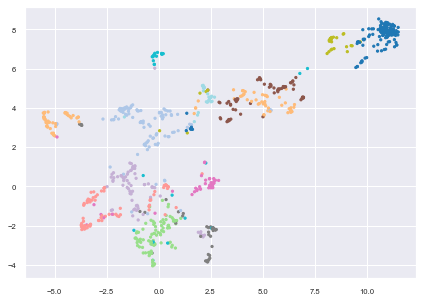

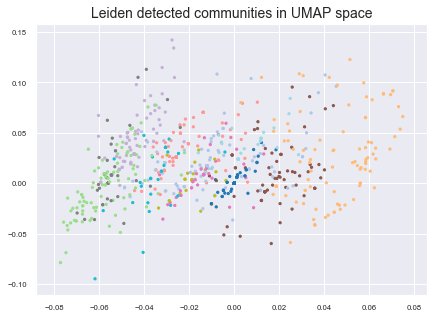

/Users/colinmegill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


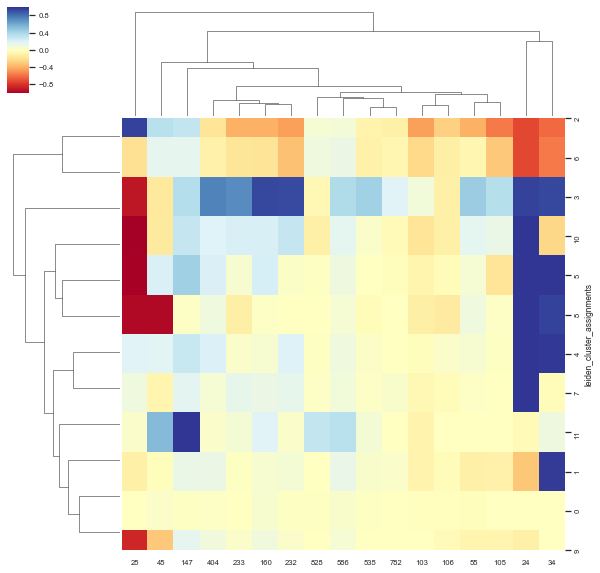

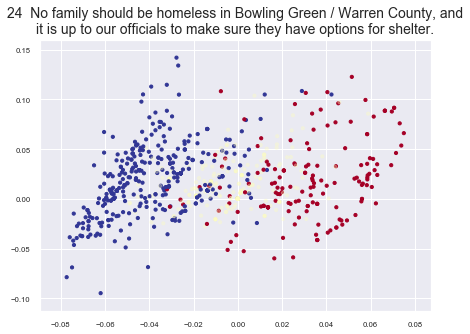

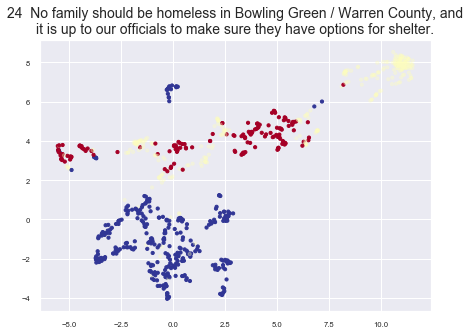

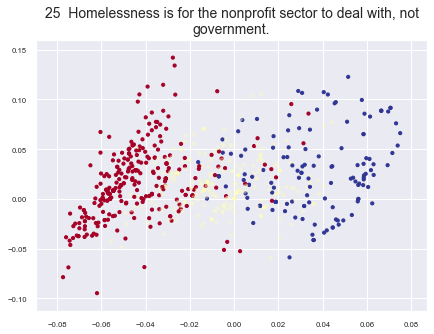

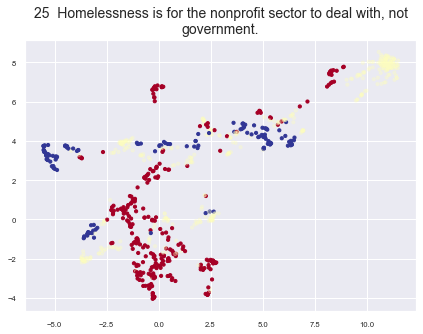

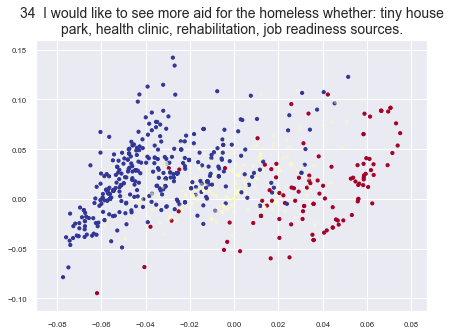

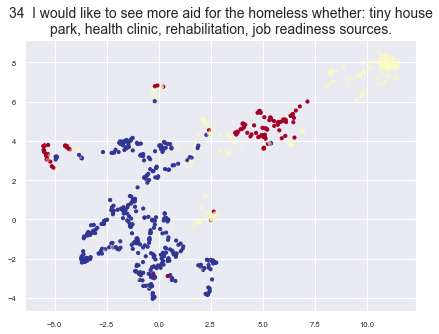

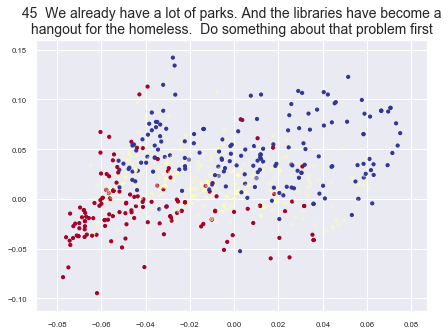

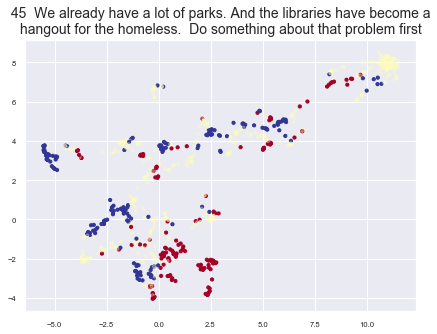

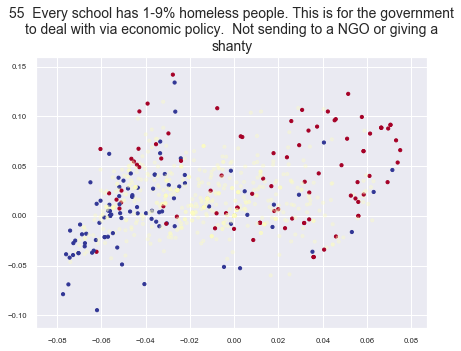

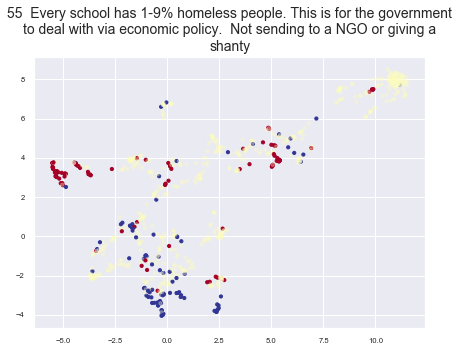

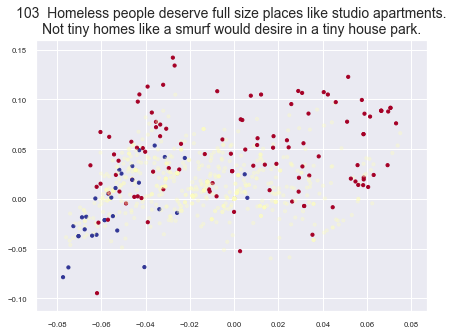

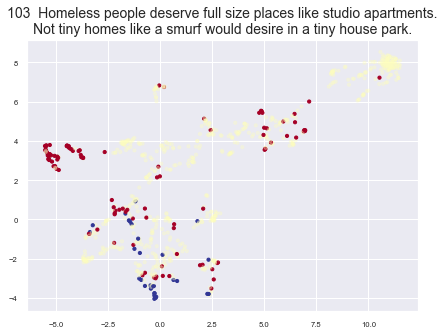

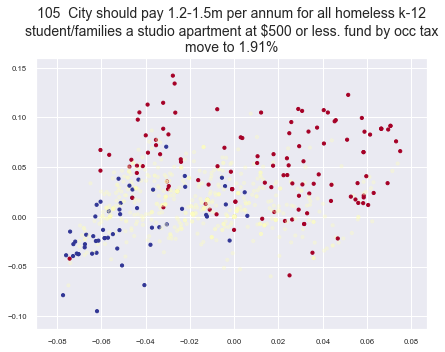

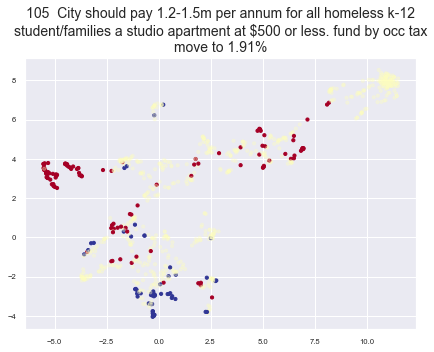

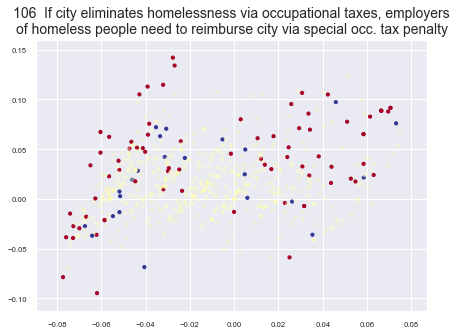

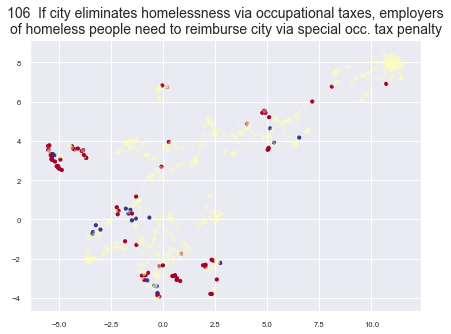

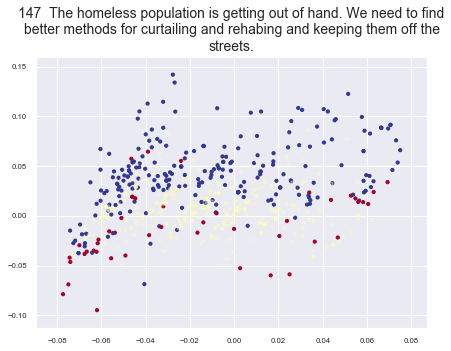

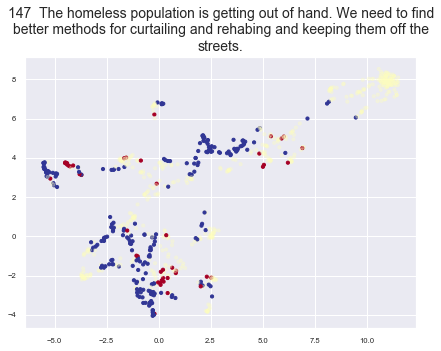

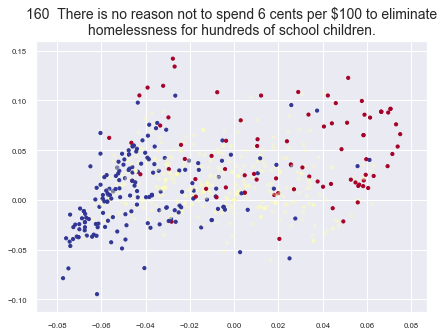

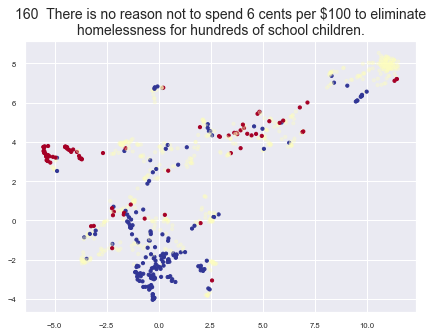

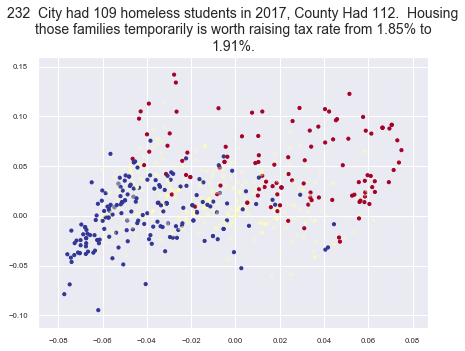

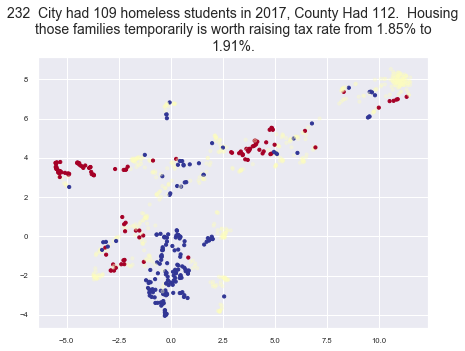

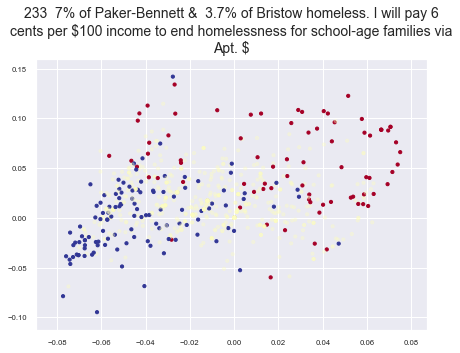

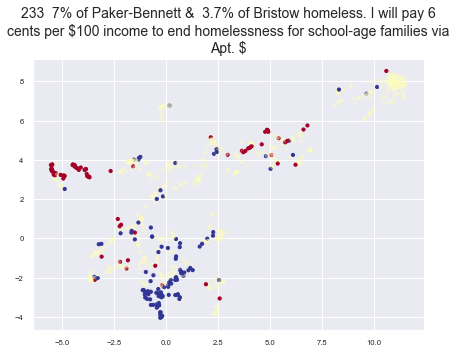

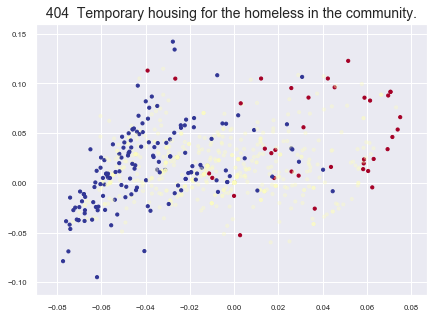

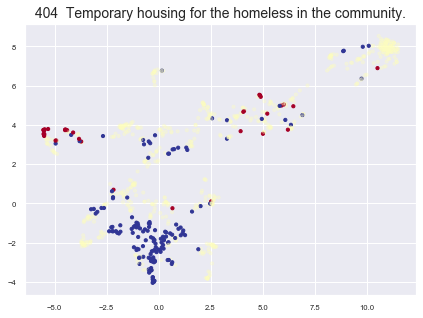

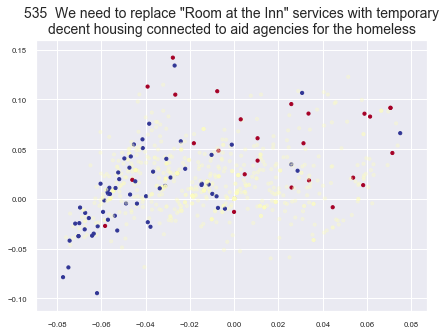

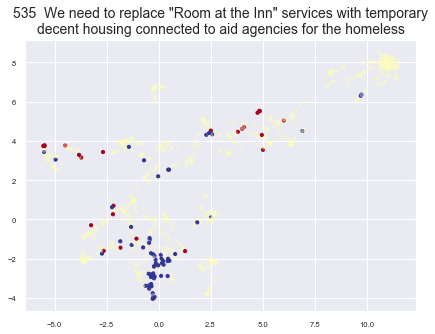

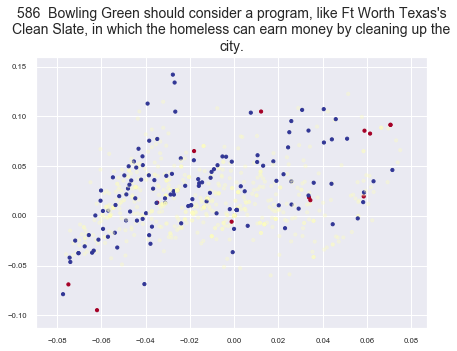

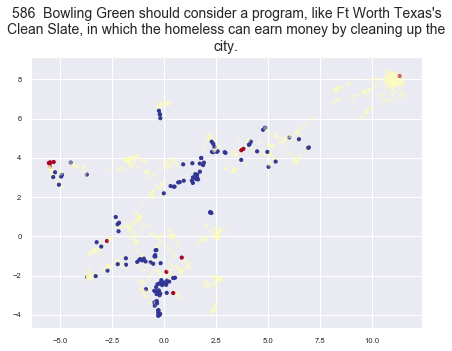

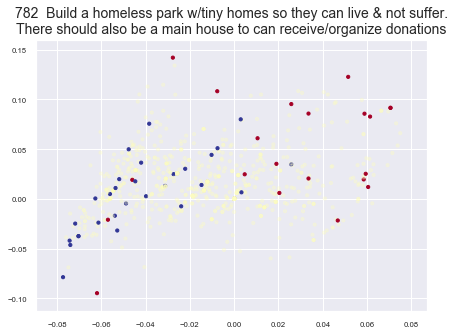

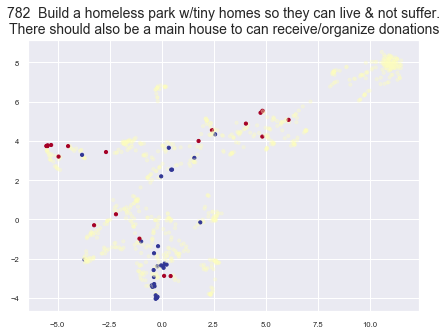

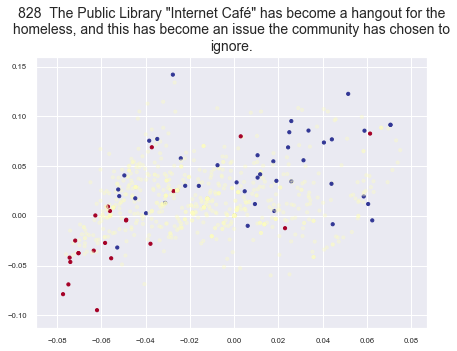

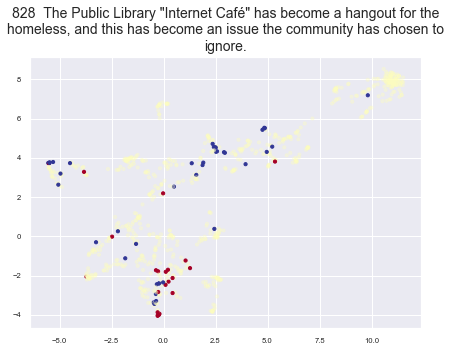

In [125]:
polis_subconversation(vals_homelessness, statements_about_homelessness)

# All

Explained variance: [0.13418707 0.07046537]


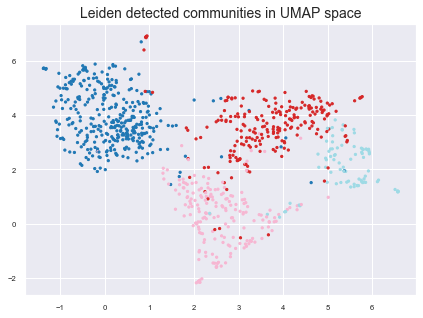

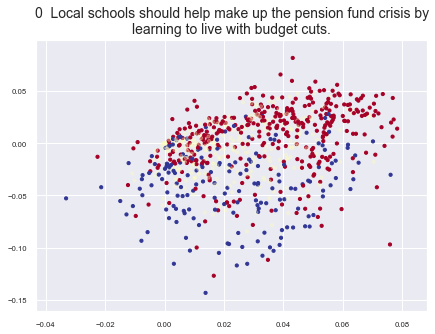

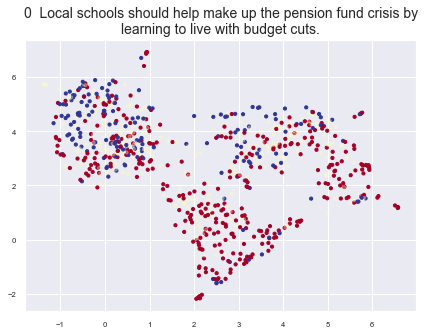

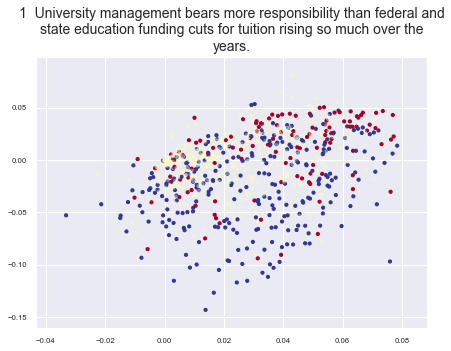

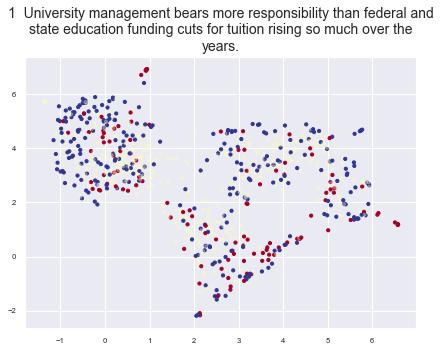

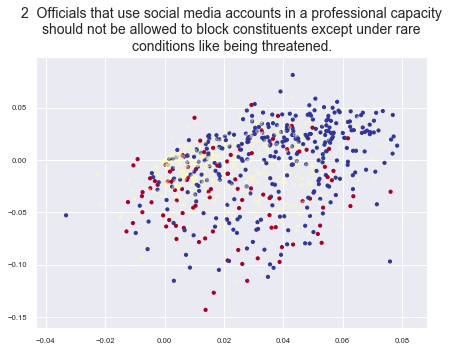

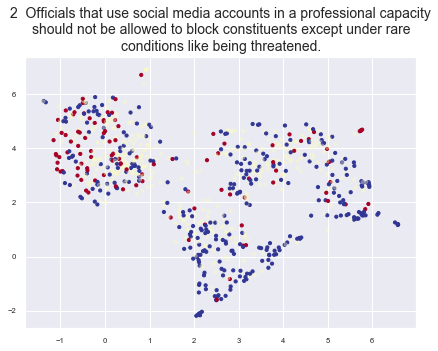

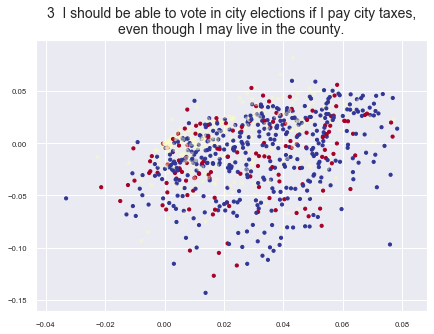

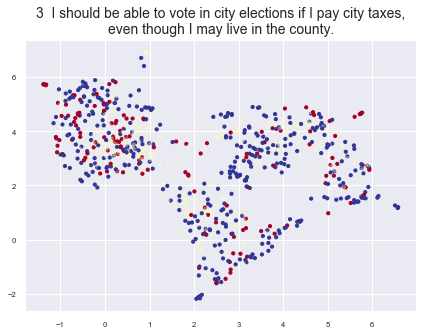

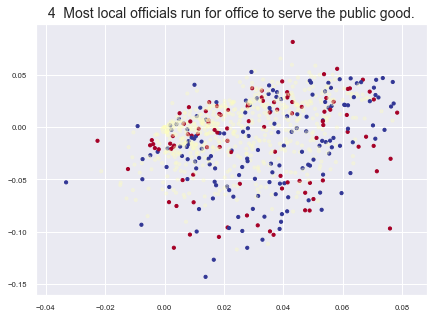

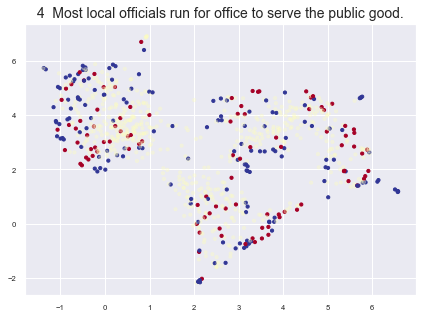

In [127]:
coords, explained_variance = polis_pca(vals_all_in, 2)
print("Explained variance:", explained_variance)

embedding = polis_umap(vals_all_in, 4)

leidenClusters = polis_leiden(vals_all_in, 8)

# Show clusters given umap embedding 
fig, ax = plt.subplots(figsize=(7,5))
plt.sca(ax)
ax.scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    c=leidenClusters,
    cmap="tab20",
    s=5
)

ax.set_title("Leiden detected communities in UMAP space", fontsize=14)
plt.show()

for x in statements_all_in:
    if int(x) < 5:
        c(x, coords)
        c(x, embedding)